# Double Jet

With `L = 9` run the script
```
python multilevelDA/scripts/DoubleJetTruth.py
```
and this processes the output files

In [1]:
from gpuocean.SWEsimulators import ModelErrorKL, CDKLM16
from gpuocean.utils import Common, IPythonMagic

from importlib import reload

import numpy as np
import pycuda.driver as cuda
from matplotlib import pyplot as plt

plt.rcParams["image.origin"] = "lower"


In [2]:
%cuda_context_handler gpu_ctx

In [3]:
gpu_stream = cuda.Stream()

In [4]:
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

Get initial arguments from class

In [5]:
from gpuocean.utils import DoubleJetCase

In [6]:
L = 9

In [7]:
doubleJetCase = DoubleJetCase.DoubleJetCase(gpu_ctx, DoubleJetCase.DoubleJetPerturbationType.SteadyState, ny=2**L, nx=2**(L+1))
doubleJetCase_args, doubleJetCase_init, _ = doubleJetCase.getInitConditions()

In [8]:
truth_path = "/home/florianb/havvarsel/multilevelDA/doublejet/scripts/DataAssimilation/DoubleJetTruth/2023-11-02T09_33_29"

Plotting

In [38]:
days = [0, 3, 6, 10]

/home/florianb/miniforge3/envs/gpuocean/lib/python3.7/site-packages/ipykernel_launcher.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


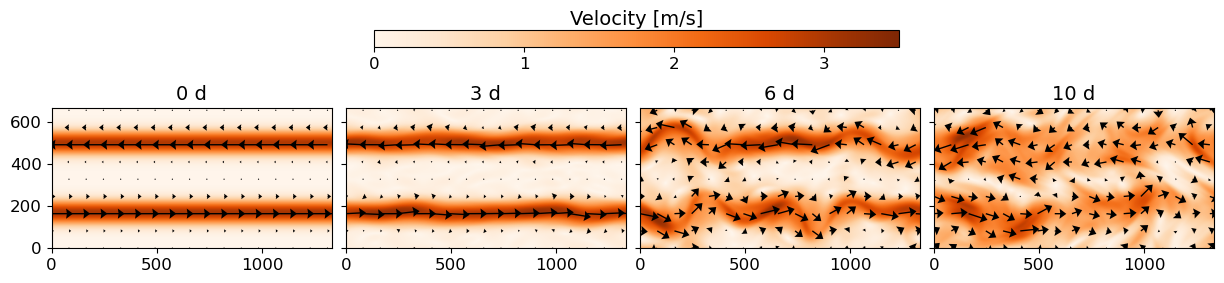

In [41]:
import matplotlib.gridspec as gridspec

# Create a grid for subplots
fig = plt.figure(figsize=(15, 3.25))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1], wspace=0.05)

H = doubleJetCase_args["H"][0][0]

for d_idx in range(len(days)): 

    day = days[d_idx]
    if day == 0:
        eta, hu, hv = doubleJetCase_init["eta0"], doubleJetCase_init["hu0"], doubleJetCase_init["hv0"]
    else:
        eta, hu, hv = np.load(truth_path+"/truth_"+str(day*24*3600)+".npy")
    
    u = hu/(H + eta)
    v = hv/(H + eta)

    V = np.sqrt(u**2 + v**2)

    extent = [0, doubleJetCase_args["dx"]*doubleJetCase_args["nx"]/1000, 0, doubleJetCase_args["dy"]*doubleJetCase_args["ny"]/1000]

    ax = plt.subplot(gs[d_idx])
    ax.set_title(str(day)+" d", fontsize=14)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    if d_idx>0:
        ax.set_yticklabels([])
    im = ax.imshow(V, extent=extent, cmap=plt.cm.Oranges, vmin=0.0, vmax=3.5)


    x = np.arange(doubleJetCase_args["dx"]/2, doubleJetCase_args["nx"]*doubleJetCase_args["dx"], doubleJetCase_args["dx"])/1000
    y = np.arange(doubleJetCase_args["dy"]/2, doubleJetCase_args["ny"]*doubleJetCase_args["dy"], doubleJetCase_args["dy"])/1000
    xint = 63 #31
    yint = 63 #31
    ax.quiver(x[::xint], y[::yint], u[::yint, ::xint], v[::yint, ::xint], scale=40, headwidth=7.5)

    
cbar_ax = fig.add_axes([0.34, 0.9, 0.35, 0.05])  # Position and dimensions of the colorbar
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal',  ticks=[0, 1, 2, 3])
cbar.set_label(label="Velocity [m/s]", size=14)#, labelpad=-50)

cbar.ax.xaxis.set_ticks_position('bottom')
cbar.ax.xaxis.set_label_position('top')

cbar.ax.tick_params(labelsize=12)

# Adjust layout for better spacing
plt.tight_layout()

plt.savefig("DoubleJet-Truth4paper.pdf", bbox_inches="tight", dpi=300)